In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [3]:
%matplotlib inline
np.set_printoptions(precision=3)

In [4]:
def plot_series(times, *all_values):
    plt.figure(figsize=(15, 5))
    for values in all_values:
        plt.plot(times, values)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
@dataclass
class Metrics:
    mse: float
    rmse: float
    mae: float

    def __repr__(self):
        return f"MSE={self.mse:.3f}, RMSE={self.rmse:.3f}, MAE={self.mae:.3f}"

def eval_metrics(outputs, targets):
    mse = np.mean(np.power(outputs - targets, 2))
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    return Metrics(mse=mse, rmse=rmse, mae=mae)

In [6]:
def trend(times, slope):
    return slope * times

def seasonal_pattern(season_times):
    """
    The first 10% of the season has values cos(7πt) and remaining 90% have values 1/exp(5t)
    
    Args:
        season_times (ndarray): An array with values between 0.0 and 1.0 but repeating in a pattern.
        e.g., 0.0, 0.25, 0.5, 0.75, 1.0, 0.0, 0.25, 0.5, 0.75, ...
    
    Returns:
        ndarray: of the same length as season_times, except the first 10% of the season is one function and the remaining 90% is another function.
    """
    return np.where(season_times < 0.4, np.cos(season_times * 2 * np.pi), 1/np.exp(3 * season_times))

def seasonality(times, period, amplitude=1, phase=0):
    # Convert times into a repeating array with values between 0 and 1.
    season_times = ((times + phase) % period) / period
    return amplitude * seasonal_pattern(season_times)

def noise(times, noise_level, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.standard_normal(len(times)) * noise_level

In [7]:
times = np.arange(4*365 + 1, dtype=np.float32)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
series = baseline + trend(times, slope) + seasonality(times, period=365, amplitude=amplitude) + noise(times, noise_level, seed=42)

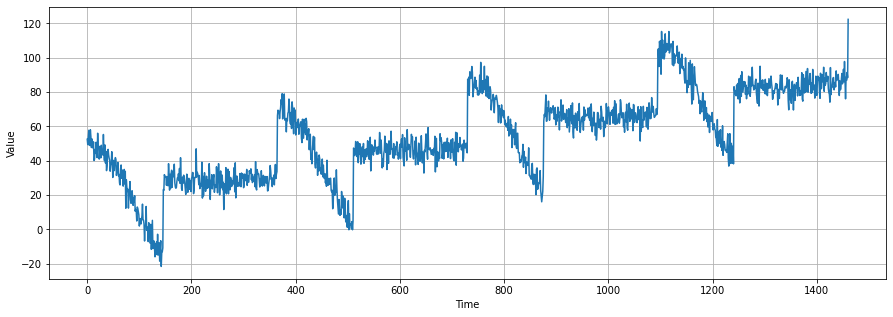

In [8]:
plot_series(times, series)

In [9]:
split_time = 1000

train_times = times[:split_time]
train_series = series[:split_time]
print(train_times.shape, train_series.shape)

val_times = times[split_time:]
val_series = series[split_time:]
print(val_times.shape, val_series.shape)

(1000,) (1000,)
(461,) (461,)


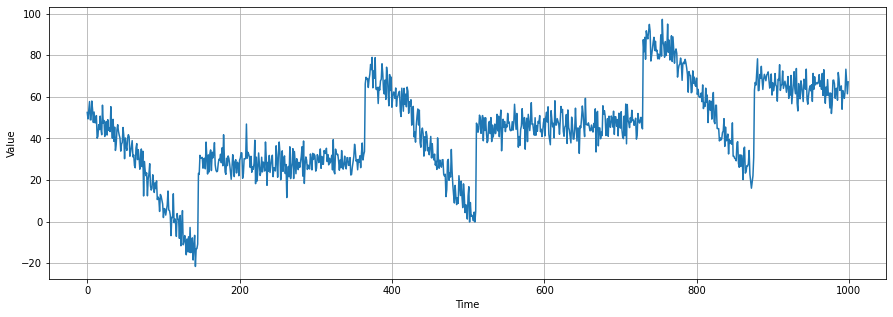

In [10]:
plot_series(train_times, train_series)

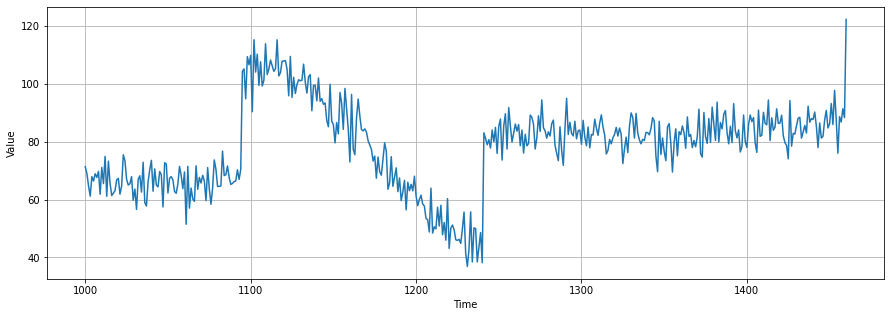

In [11]:
plot_series(val_times, val_series)

## Naive Forecast
The forecast for today is the value of yesterday, i.e., 
$$
\hat y_t = y_{t-1} \\
\hat y_0 = nan \\
\hat y_1 = y_0 \\
\hat y_{1461} = y_{1460}
$$

![naive](./naive.png)

In [12]:
forecast = np.full_like(series, fill_value=np.nan)
forecast[1:] = series[:-1]
t = np.random.randint(0, len(times)-1)
print(f"Value at {t-1} is {series[t-1]:.3f}. Forecast for {t} is {forecast[t]:.3f}")

Value at 1369 is 78.233. Forecast for 1370 is 78.233


In [13]:
val_forecast = forecast[split_time:]
eval_metrics(val_forecast, val_series)

MSE=61.828, RMSE=7.863, MAE=5.938

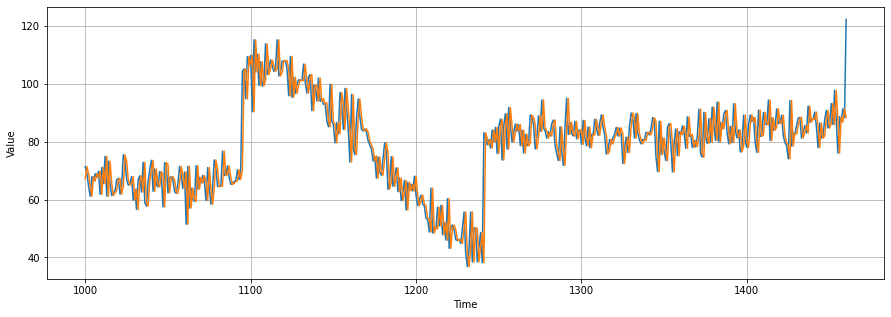

In [14]:
plot_series(val_times, val_series, val_forecast)

Note that the forecast for time step 1461 is the same as the value for 1460, but the actual value at 1461 is a spike.

## Moving Average
The forecast for today is the average of the last `n` values, i.e., -

$$
\hat y_t = \frac1n \sum_{i=t-n}^{t-1} y_i
$$

For `n=15` (say), the forecasts work out to be -
$$
\hat y_0 = nan \\
::: \\
\hat y_{14} = nan \\
\hat y_{15} = \frac{1}{15} \left( y_0 + y_1 + ... + y_{14} \right) \\
\hat y_{1461} = \frac{1}{15} \left( y_{1446} + y_{1447} + y_{1460} \right) \\
$$

![moving-avg](./moving-avg.png)

In [15]:
def moving_avg(values, window, start=0):
    output = np.full_like(values, fill_value=np.nan)
    for t in range(start+window, len(values[start:])):
        output[t] = np.mean(values[t-window:t])
    return output

In [16]:
forecast = moving_avg(series, 30)

In [17]:
val_forecast = forecast[split_time:]
eval_metrics(val_forecast, val_series)

MSE=106.675, RMSE=10.328, MAE=7.142

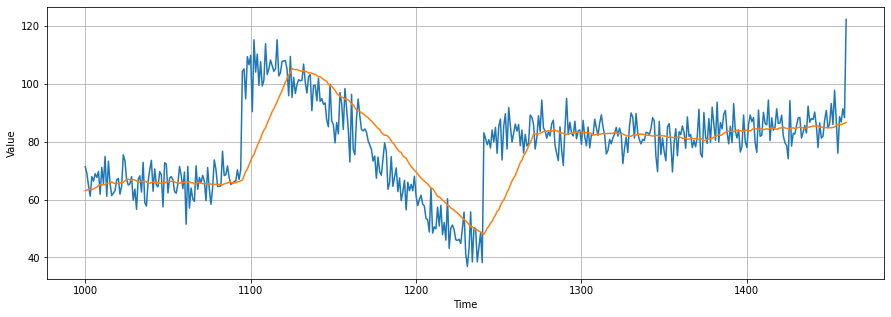

In [18]:
plot_series(val_times, val_series, val_forecast)

## Diff Series Moving Average
This is a two step process, first we get rid of seasonality, and then calculate the moving average of the resulting diff series. Lets say the seasonality period is `T` and our moving average window is `n`, then -

$$
z_t = y_t - y_{t-T} \\
\hat z_t = \frac1n \sum_{i=t-n}^{t-1} z_i \\
\hat y_t = \hat z_t + y_{t-T} \\
$$

Now lets plug in the values of `T=365` and `n=50` in the above formulae. First we calculate the diff series -

$$
z_0 = nan \\
::: \\
z_{365} = y_{365} - y_0 \\
z_{1461} = y_{1461} - y_{1096} \\
$$

Then we forecast the diff series -

$$
\hat z_0 = nan \\
::: \\
\hat z_{415} = \frac{1}{50} \left( z_{365} + z_{366} + ... + z_{414} \right) \\
\hat z_{1461} = \frac{1}{50} \left( z_{1411} + z_{1412} + ... + z_{1460} \right) \\
$$

And finally we forecast the original series -

$$
\hat y_0 = nan \\
::: \\
\hat y_{415} = \hat z_{415} + y_{50} \\
\hat y_{1461} = \hat z_{1461} + y_{1096} \\
$$

![diff-ma](./diff-ma.png)

In [19]:
z = np.full_like(series, fill_value=np.nan)
z[365:] = series[365:] - series[:-365]

In [20]:
def verify_diff(y, z, t):
    print(f"{t}-365={t-365} z[{t}]={z[t]:.3f}, y[{t}]={y[t]:.3f}, y[{t-365}]={y[t-365]:.3f}, y[{t}]-y[{t-365}]={(y[t] - y[t-365]):.3f}")    

In [21]:
verify_diff(series, z, 365)
verify_diff(series, z, np.random.randint(365, 1461))

365-365=0 z[365]=13.760, y[365]=66.244, y[0]=52.484, y[365]-y[0]=13.760
681-365=316 z[681]=9.195, y[681]=41.384, y[316]=32.189, y[681]-y[316]=9.195


In [22]:
z_hat = moving_avg(z, 50)
print(z_hat[365+50-1], z_hat[365+50], z_hat[365+50+1])

nan 19.628149897764303 19.610686309658874


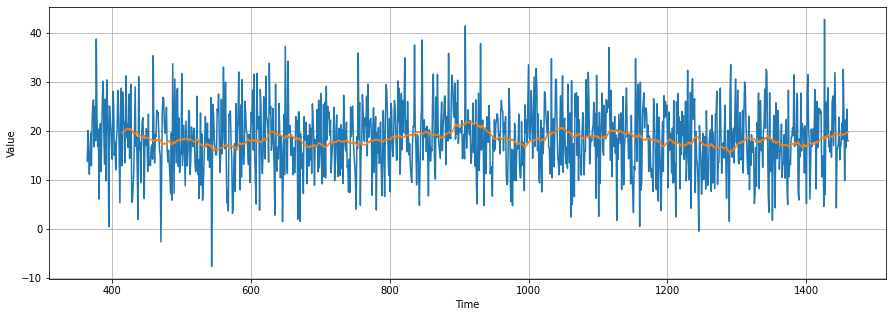

In [23]:
plot_series(times, z, z_hat)

In [24]:
forecast = np.full_like(series, fill_value=np.nan)
forecast[365+50:] = z_hat[365+50:] + series[50:-365]

In [25]:
val_forecast = forecast[split_time:]
eval_metrics(val_forecast, val_series)

MSE=52.974, RMSE=7.278, MAE=5.839

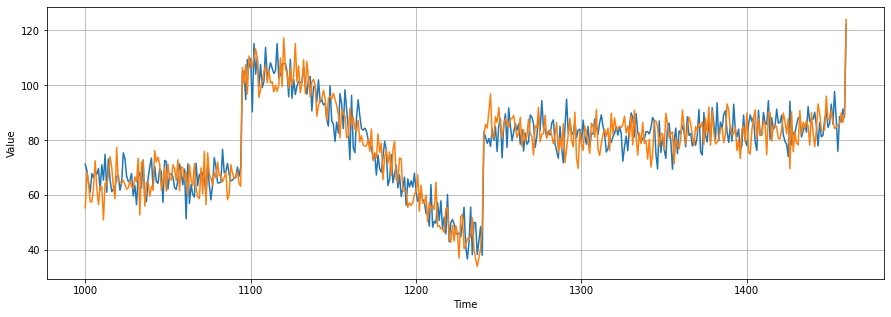

In [26]:
plot_series(val_times, val_series, val_forecast)

## Moving Average Diff Series Moving Average
This is very much like diff series moving average, except in the last step. In the earlier case we were adding the actual data from `T` time steps ago, in this we first smooth out the original seasonal data, and add the smoothed value.

$$
a_t = \frac1m \sum_{i=t-m}^{t-1} y_t \\
z_t = y_t - y_{t-T} \\
\hat z_t = \frac1n \sum{i=t-n}^{t-1} z_t \\
\hat y_t = \hat z_t + a_{t-T} \\
$$

While the last equation makes sense, in the implementation the course instructor did the following:
$$
\hat y_t = \hat z_t + a_{t-T+\frac{m}{2}}
$$

In [77]:
a = moving_avg(series, 10)
forecast = np.full_like(series, fill_value=np.nan)
for t in range(365+50,len(forecast)):
    forecast[t] = z_hat[t] + a[t-360]  # Don't know why this is t-360 instead of t-365

In [75]:
val_forecast = forecast[split_time:]
eval_metrics(val_forecast, val_series)

MSE=33.452, RMSE=5.784, MAE=4.569

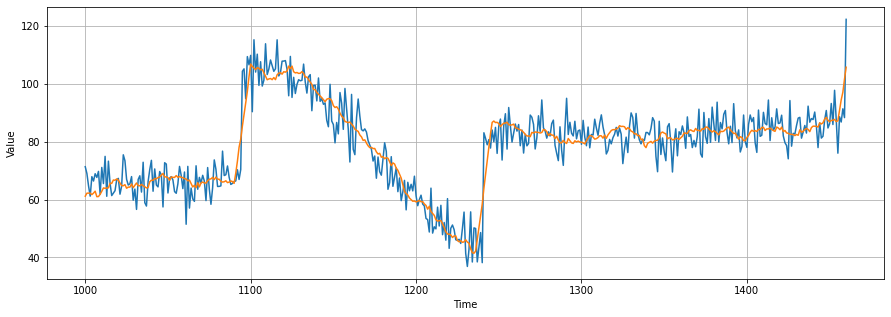

In [78]:
plot_series(val_times, val_series, val_forecast)

In [79]:
a = moving_avg(series, 14)
forecast = np.full_like(series, fill_value=np.nan)
for t in range(365+50,len(forecast)):
    forecast[t] = z_hat[t] + a[t-358]
val_forecast = forecast[split_time:]
eval_metrics(val_forecast, val_series)

MSE=34.840, RMSE=5.903, MAE=4.624